# Process micro-benchmark outputs

This notebook extracts Loop time values from the organized files in `apps/<benchmark>/`.
By default it uses `dvfs` outputs; change `group` to `energy` to switch.


In [166]:
from pathlib import Path
import re

group = 'dvfs'  # change to 'energy' if needed
baseline_freq = '2.5GHz'
selected_freqs = ['0.8GHz', '1.0GHz', '1.3GHz', '1.6GHz', '1.9GHz', '2.2GHz', '2.5GHz']  # e.g., ['0.8GHz', '1.0GHz']; leave empty to use all

loop_time_re = re.compile(r'Loop time:\s*([0-9.]+)\s*seconds')
freq_re = re.compile(rf'_(?:{group})_([0-9.]+GHz)\.out$')

def find_apps_dir(start: Path) -> Path:
    current = start.resolve()
    for _ in range(6):
        candidate = current / 'apps'
        if candidate.is_dir():
            return candidate
        if current.parent == current:
            break
        current = current.parent
    raise FileNotFoundError('No apps directory found. Run from repo root or set apps_dir manually.')

apps_dir = find_apps_dir(Path.cwd())

def parse_loop_time(path: Path):
    for line in path.read_text().splitlines():
        match = loop_time_re.search(line)
        if match:
            return float(match.group(1))
    return None

def extract_freq(path: Path):
    match = freq_re.search(path.name)
    if not match:
        return None
    return match.group(1)

def freq_value(freq: str):
    return float(freq.replace('GHz', ''))

raw_results = {}
perf_results = {}
missing_baseline = []
for app_dir in sorted(apps_dir.iterdir()):
    if not app_dir.is_dir():
        continue
    entries = []
    for out_file in sorted(app_dir.glob(f'*_{group}_*.out')):
        freq = extract_freq(out_file)
        if not freq:
            continue
        if selected_freqs and freq not in selected_freqs:
            continue
        loop_time = parse_loop_time(out_file)
        if loop_time is None:
            continue
        entries.append((freq, loop_time))
    if not entries:
        continue
    entries.sort(key=lambda item: freq_value(item[0]))
    raw_results[app_dir.name] = entries
    base = None
    for freq, time in entries:
        if freq == baseline_freq:
            base = time
            break
    if base is None:
        missing_baseline.append(app_dir.name)
        continue
    perf_entries = [(freq, base / time) for freq, time in entries]
    perf_results[app_dir.name] = perf_entries

perf_results


{'atomic_fight': [('0.8GHz', 0.11388609441004369),
  ('1.0GHz', 0.3465725192970615),
  ('1.3GHz', 0.3564447288461727),
  ('1.6GHz', 0.40799543062166005),
  ('1.9GHz', 0.4907517545746414),
  ('2.2GHz', 0.5682959174960384),
  ('2.5GHz', 1.0)],
 'branch_mispredict': [('0.8GHz', 0.318590765295206),
  ('1.0GHz', 0.39922226121359705),
  ('1.3GHz', 0.5201300951068345),
  ('1.6GHz', 0.6399465311632894),
  ('1.9GHz', 0.7618951696464165),
  ('2.2GHz', 0.8799575029246475),
  ('2.5GHz', 1.0)],
 'dgemm': [('0.8GHz', 0.3262803845975467),
  ('1.0GHz', 0.408113537906147),
  ('1.3GHz', 0.5308061820286564),
  ('1.6GHz', 0.652077372837848),
  ('1.9GHz', 0.7718931906966868),
  ('2.2GHz', 0.8884247482075923),
  ('2.5GHz', 1.0)],
 'fft_mix': [('0.8GHz', 0.31888569642674786),
  ('1.0GHz', 0.39768488366448224),
  ('1.3GHz', 0.519618432859857),
  ('1.6GHz', 0.6470850419121406),
  ('1.9GHz', 0.7626185342468861),
  ('2.2GHz', 0.8836359278845566),
  ('2.5GHz', 1.0)],
 'icache_thrash': [('0.8GHz', 0.32334452453249

In [167]:
# Energy profile helpers (from process_apps_energy.ipynb)
from pathlib import Path
from typing import Dict, List, Sequence
import pandas as pd

SUM_FIELDS = {
    'Energy [J]',
    'Power [W]',
    'Energy PP0 [J]',
    'Power PP0 [W]',
    'Energy DRAM [J]',
    'Power DRAM [W]',
    'Energy PLATFORM [J]',
    'Power PLATFORM [W]',
    'Memory read bandwidth [MBytes/s]',
    'Memory read data volume [GBytes]',
    'Memory write bandwidth [MBytes/s]',
    'Memory write data volume [GBytes]',
    'Memory bandwidth [MBytes/s]',
    'Memory data volume [GBytes]',
    'L3 request rate',
    'L3 miss rate',
    'L3 miss ratio',
}

def find_apps_dir(start: Path) -> Path:
    current = start.resolve()
    for _ in range(6):
        candidate = current / 'apps'
        if candidate.is_dir():
            return candidate
        if current.parent == current:
            break
        current = current.parent
    raise FileNotFoundError('No apps directory found. Run from repo root or set apps_dir manually.')

def parse_headers(stdout_path: Path) -> List[Sequence[str]]:
    headers: List[Sequence[str]] = []
    with stdout_path.open() as handle:
        for line in handle:
            if line.startswith('# GID|'):
                parts = line.lstrip('#').strip().split('|')
                fields = parts[3:]
                if fields:
                    headers.append(fields)
    if not headers:
        raise RuntimeError(f'No LIKWID headers found in {stdout_path}')
    return headers

def aggregate_metric(values: Sequence[float], field: str) -> float:
    if not values:
        raise KeyError(f'Missing values for field {field}')
    if field in SUM_FIELDS:
        return float(sum(values))
    return float(sum(values) / len(values))

def load_energy_profile(app: str, freq: str, *, apps_dir: Path | None = None, group: str = 'energy') -> pd.DataFrame:
    if apps_dir is None:
        apps_dir = find_apps_dir(Path.cwd())

    out_path = apps_dir / app / f'{app}_{group}_{freq}.out'
    prof_path = apps_dir / app / f'{app}_{group}_{freq}.prof'
    if not out_path.exists():
        raise FileNotFoundError(f'Missing header file: {out_path}')
    if not prof_path.exists():
        raise FileNotFoundError(f'Missing profile file: {prof_path}')

    headers = parse_headers(out_path)
    if len(headers) != 1:
        print(f'Warning: expected 1 header set, found {len(headers)} in {out_path.name}')
    header = headers[0]
    global_field = header[0]
    metric_fields = header[1:]

    rows: List[Dict[str, float]] = []
    in_loop = False
    saw_start = False
    saw_end = False

    with prof_path.open() as handle:
        for raw_line in handle:
            line = raw_line.strip()
            if not line:
                continue
            if line.startswith('LOOP_START_REL'):
                in_loop = True
                saw_start = True
                continue
            if line.startswith('LOOP_END_REL'):
                in_loop = False
                saw_end = True
                break
            if not in_loop:
                continue
            if line.startswith('#'):
                continue
            parts = line.split(',')
            if len(parts) < 4:
                continue
            gid = int(parts[0])
            metrics_count = int(parts[1])
            cpu_count = int(parts[2])
            values = [float(val) for val in parts[3:]]

            if metrics_count != len(metric_fields):
                raise ValueError(
                    f'Header mismatch: expected {len(metric_fields)} metrics, got {metrics_count} in {prof_path.name}'
                )

            expected_values = 1 + metrics_count * cpu_count
            if len(values) != expected_values:
                raise ValueError(
                    f'Expected {expected_values} numeric entries, got {len(values)} in {prof_path.name}'
                )

            global_value = values[0]
            metric_values = values[1:]

            extracted: Dict[str, float] = {global_field: global_value}
            for idx, field in enumerate(metric_fields):
                start = idx * cpu_count
                end = start + cpu_count
                segment = metric_values[start:end]
                if not segment:
                    continue
                extracted[field] = aggregate_metric(segment, field)

            extracted['gid'] = gid
            rows.append(extracted)

    if not saw_start:
        raise RuntimeError(f'LOOP_START_REL marker not found in {prof_path.name}')
    if not saw_end:
        raise RuntimeError(f'LOOP_END_REL marker not found in {prof_path.name}')
    if not rows:
        raise RuntimeError(f'No samples found between loop markers in {prof_path.name}')

    return pd.DataFrame(rows)


In [168]:
# Total energy per benchmark/frequency (within LOOP_START_REL/LOOP_END_REL)
from pathlib import Path
import re

energy_group = 'energy'
power_field = 'Power [W]'
energy_freq_re = re.compile(rf'_(?:{energy_group})_([0-9.]+GHz)\.out$')

apps_dir = find_apps_dir(Path.cwd())

def extract_energy_freq(path: Path):
    match = energy_freq_re.search(path.name)
    if not match:
        return None
    return match.group(1)

energy_raw = {}
energy_results = {}
missing_energy_baseline = []
for app_dir in sorted(apps_dir.iterdir()):
    if not app_dir.is_dir():
        continue
    entries = []
    for out_file in sorted(app_dir.glob(f'*_{energy_group}_*.out')):
        freq = extract_energy_freq(out_file)
        if not freq:
            continue
        if selected_freqs and freq not in selected_freqs:
            continue
        df = load_energy_profile(app_dir.name, freq, apps_dir=apps_dir, group=energy_group)
        if power_field not in df.columns:
            raise KeyError(f'Missing {power_field} in {app_dir.name} {freq}')
        time_field = df.columns[0]
        if time_field == 'gid':
            raise KeyError('Time field not found in energy profile data')
        times = df[time_field].to_numpy()
        powers = df[power_field].to_numpy()
        if len(times) < 2:
            raise RuntimeError(f'Not enough samples to integrate power for {app_dir.name} {freq}')
        deltas = times[1:] - times[:-1]
        total_energy = float((powers[:-1] * deltas).sum())
        entries.append((freq, total_energy))
    if not entries:
        continue
    entries.sort(key=lambda item: freq_value(item[0]))
    energy_raw[app_dir.name] = entries
    base = None
    for freq, energy in entries:
        if freq == baseline_freq:
            base = energy
            break
    if base is None:
        missing_energy_baseline.append(app_dir.name)
        continue
    rel_entries = [(freq, energy / base) for freq, energy in entries]
    energy_results[app_dir.name] = rel_entries

energy_results


{'atomic_fight': [('0.8GHz', 5.187882218447148),
  ('1.0GHz', 1.7335146244658048),
  ('1.3GHz', 1.869465878366135),
  ('1.6GHz', 1.633749082148695),
  ('1.9GHz', 1.3843292883079872),
  ('2.2GHz', 1.1293973801471313),
  ('2.5GHz', 1.0)],
 'branch_mispredict': [('0.8GHz', 2.6361138258219037),
  ('1.0GHz', 2.1161825475931444),
  ('1.3GHz', 1.6778467735176992),
  ('1.6GHz', 1.4041460074625471),
  ('1.9GHz', 1.221595080308883),
  ('2.2GHz', 1.084288398767551),
  ('2.5GHz', 1.0)],
 'dgemm': [('0.8GHz', 2.1648671697045403),
  ('1.0GHz', 1.819220350030744),
  ('1.3GHz', 1.5178140255490407),
  ('1.6GHz', 1.3431661878468126),
  ('1.9GHz', 1.230224972653493),
  ('2.2GHz', 1.1256378956984556),
  ('2.5GHz', 1.0)],
 'fft_mix': [('0.8GHz', 2.3408419434910495),
  ('1.0GHz', 1.9240664704614094),
  ('1.3GHz', 1.5539954465233243),
  ('1.6GHz', 1.3238640374409731),
  ('1.9GHz', 1.1805460579539742),
  ('2.2GHz', 1.0686248426642293),
  ('2.5GHz', 1.0)],
 'icache_thrash': [('0.8GHz', 2.6940248203893487),
  (

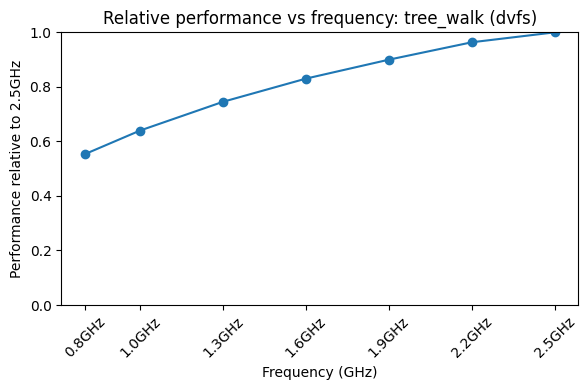

In [169]:
# Example: plot a single benchmark
import matplotlib.pyplot as plt

# app = next(iter(perf_results)) if perf_results else None
app = 'tree_walk'
if app:
    freqs = [float(f.replace('GHz', '')) for f, _ in perf_results[app]]
    labels = [f for f, _ in perf_results[app]]
    perf = [p for _, p in perf_results[app]]

    plt.figure(figsize=(6, 4))
    plt.plot(freqs, perf, marker='o')
    plt.title(f'Relative performance vs frequency: {app} ({group})')
    plt.xlabel('Frequency (GHz)')
    plt.ylabel(f'Performance relative to {baseline_freq}')
    plt.xticks(freqs, labels, rotation=45)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


In [170]:
# Benchmark groups (edit these lists to control selection)
run_fast = [
    'dgemm',
    'branch_mispredict',
    'icache_thrash',
    # 'tree_walk',
    'fft_mix',
]

feed_me = [
    'l3_stencil',
    'stream',
    'spmv',
]

system_group = [
    'pointer_chase',
    'atomic_fight',
    'mpi_bandwidth',
]

sleep_group = [
    'mpi_barrier',
    'io_write',
]

# selected = []  # e.g., ['atomic_fight', 'dgemm']; leave empty to plot all
selected = run_fast + feed_me + system_group + sleep_group

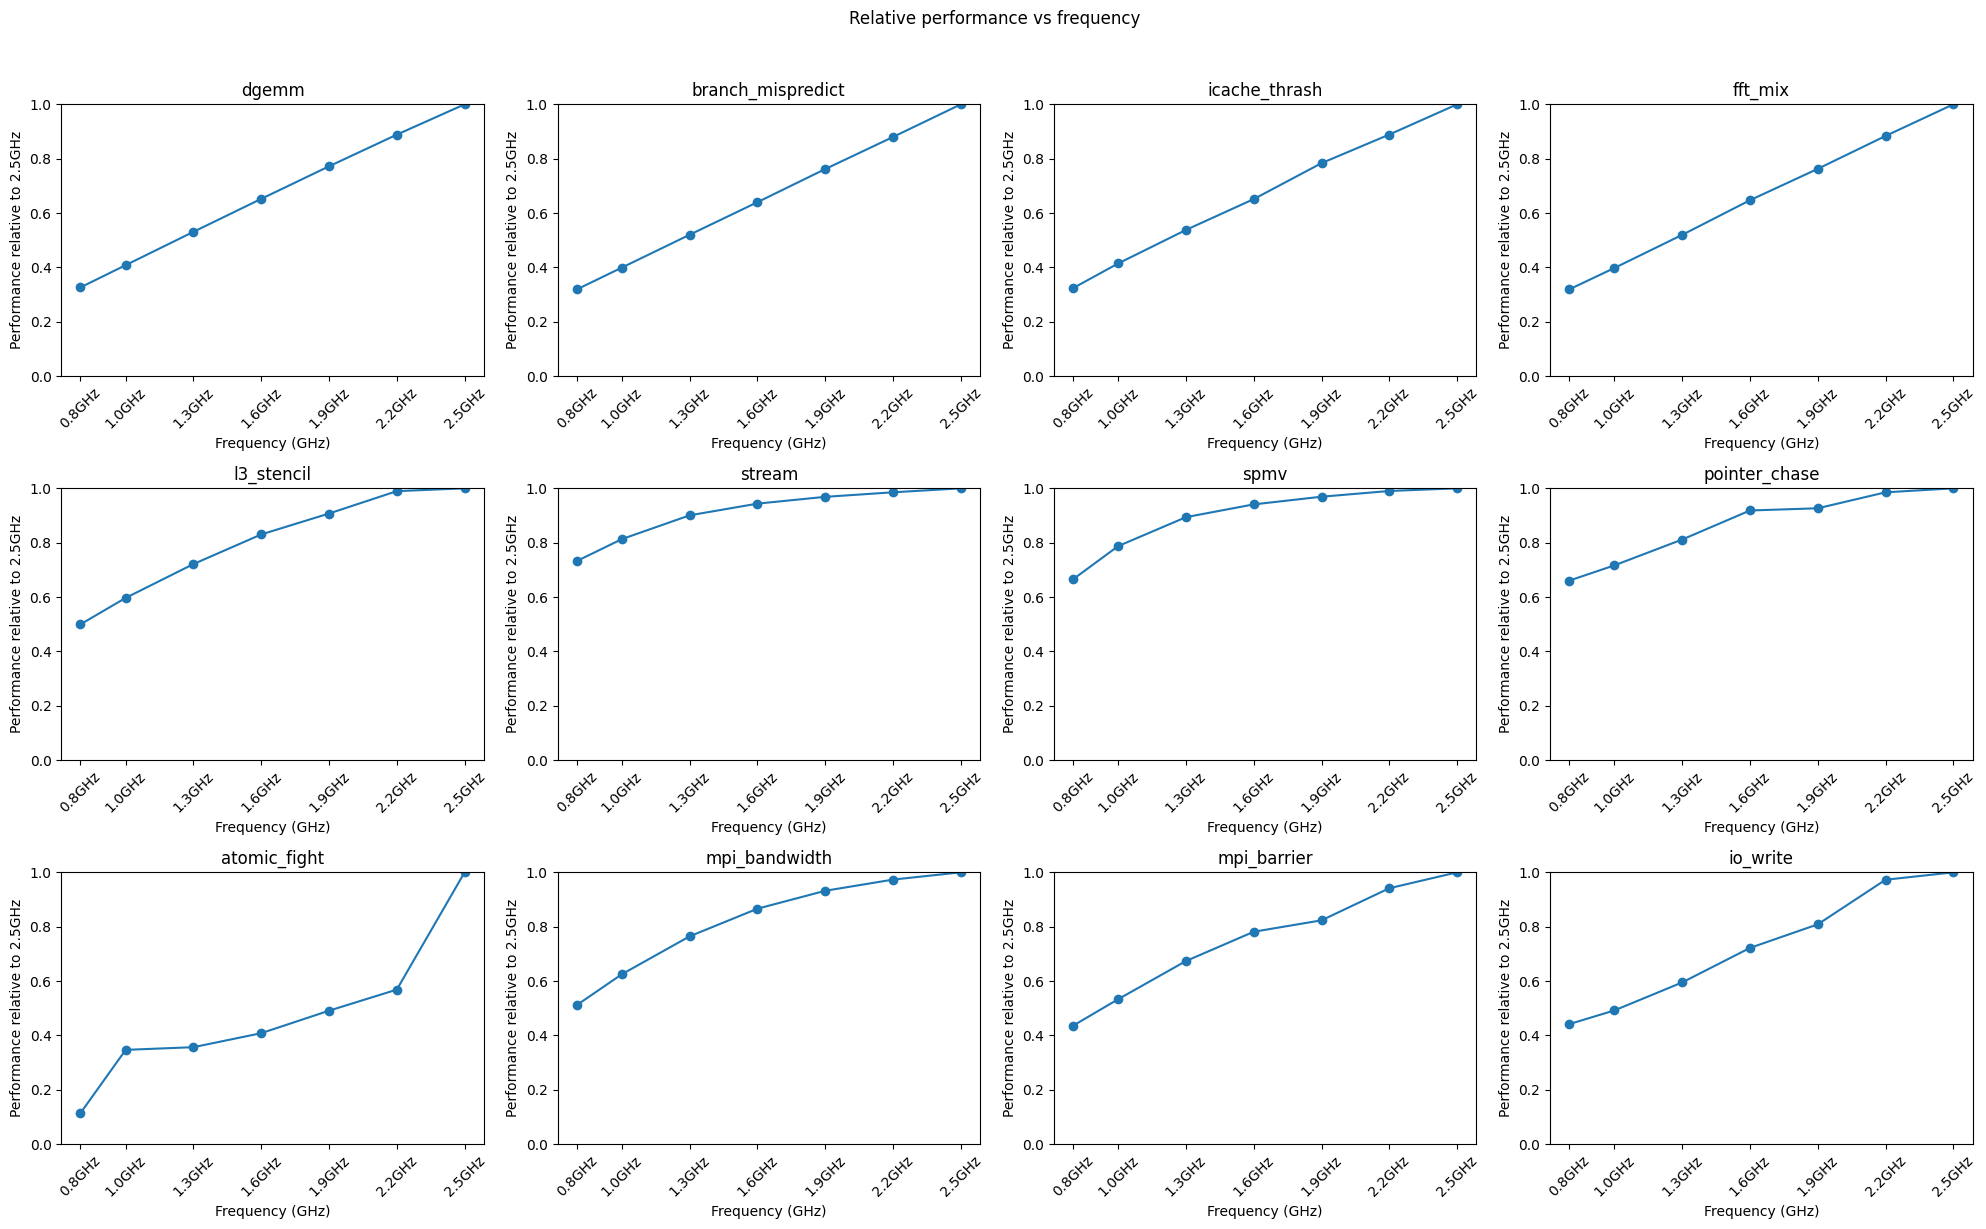

In [171]:
import math

apps = list(perf_results.keys())
if selected:
    apps = [app for app in selected if app in perf_results]

if apps:
    cols = 4
    rows = math.ceil(len(apps) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes if isinstance(axes, (list, tuple)) else axes.flatten()

    for ax, app in zip(axes, apps):
        freqs = [float(f.replace('GHz', '')) for f, _ in perf_results[app]]
        labels = [f for f, _ in perf_results[app]]
        perf = [p for _, p in perf_results[app]]
        ax.plot(freqs, perf, marker='o')
        ax.set_title(app)
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel(f'Performance relative to {baseline_freq}')
        ax.set_xticks(freqs, labels, rotation=45)
        ax.set_ylim(0, 1)

    for ax in axes[len(apps):]:
        ax.axis('off')

    fig.suptitle('Relative performance vs frequency', y=1.02)
    fig.tight_layout()
    plt.show()


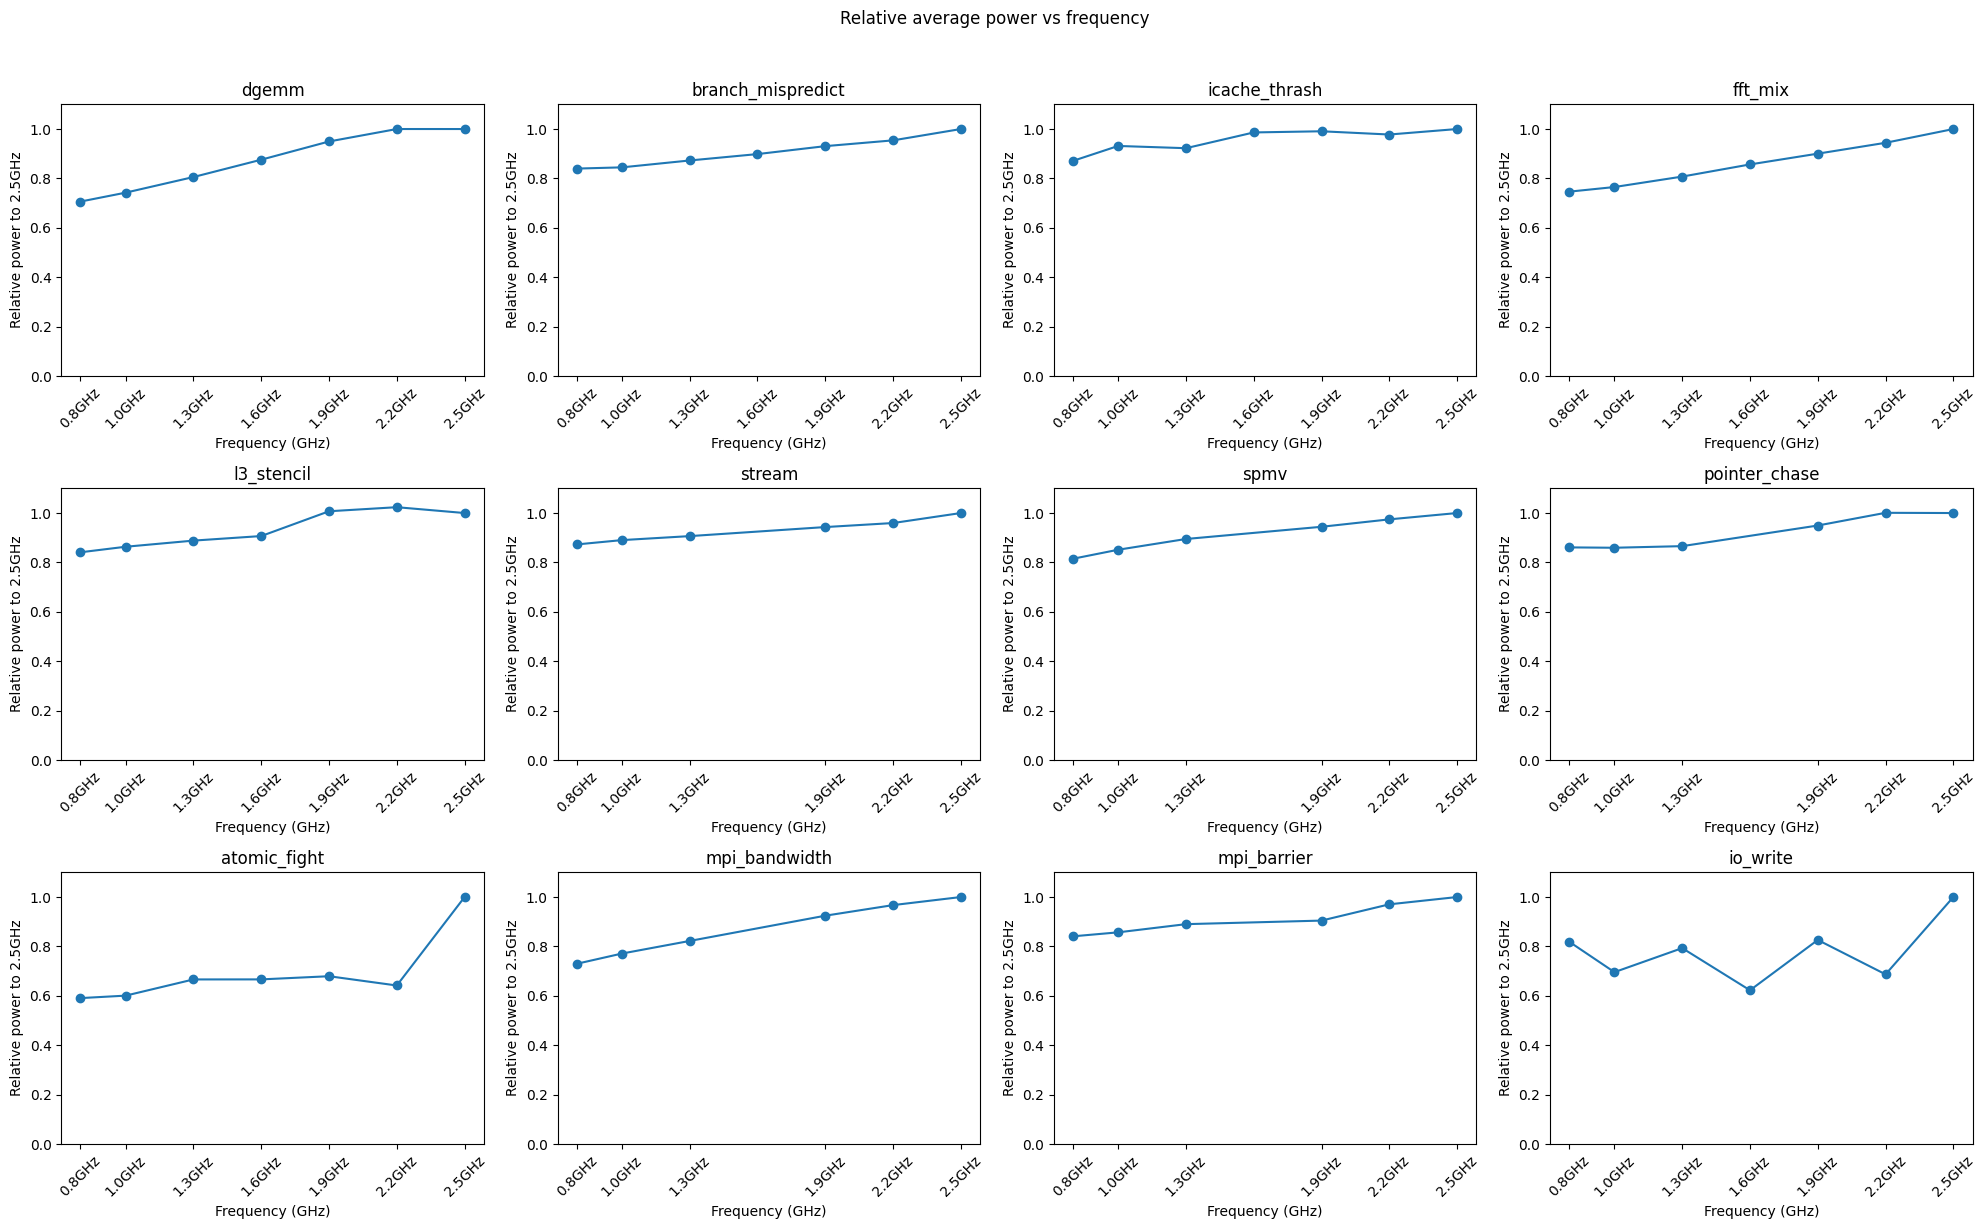

In [172]:
# Plot average power vs frequency (relative to baseline)
import math
import matplotlib.pyplot as plt

apps = list(energy_raw.keys())
if 'selected' in globals() and selected:
    apps = [app for app in selected if app in energy_raw]

def build_lookup(pairs):
    return {freq: value for freq, value in pairs}

missing_power_baseline = []

if apps:
    cols = 4
    rows = math.ceil(len(apps) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes if isinstance(axes, (list, tuple)) else axes.flatten()

    for ax, app in zip(axes, apps):
        energy_map = build_lookup(energy_raw[app])
        time_map = build_lookup(raw_results.get(app, []))
        freqs = [f for f in energy_map.keys() if f in time_map]
        freqs.sort(key=freq_value)
        avg_power = {f: energy_map[f] / time_map[f] for f in freqs}
        if baseline_freq not in avg_power:
            missing_power_baseline.append(app)
            continue
        base = avg_power[baseline_freq]
        rel_power = [avg_power[f] / base for f in freqs]
        xvals = [float(f.replace('GHz', '')) for f in freqs]
        ax.plot(xvals, rel_power, marker='o')
        ax.set_title(app)
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel(f'Relative power to {baseline_freq}')
        ax.set_xticks(xvals, freqs, rotation=45)
        ax.set_ylim(0, 1.1)

    for ax in axes[len(apps):]:
        ax.axis('off')

    fig.suptitle('Relative average power vs frequency', y=1.02)
    fig.tight_layout()
    plt.show()


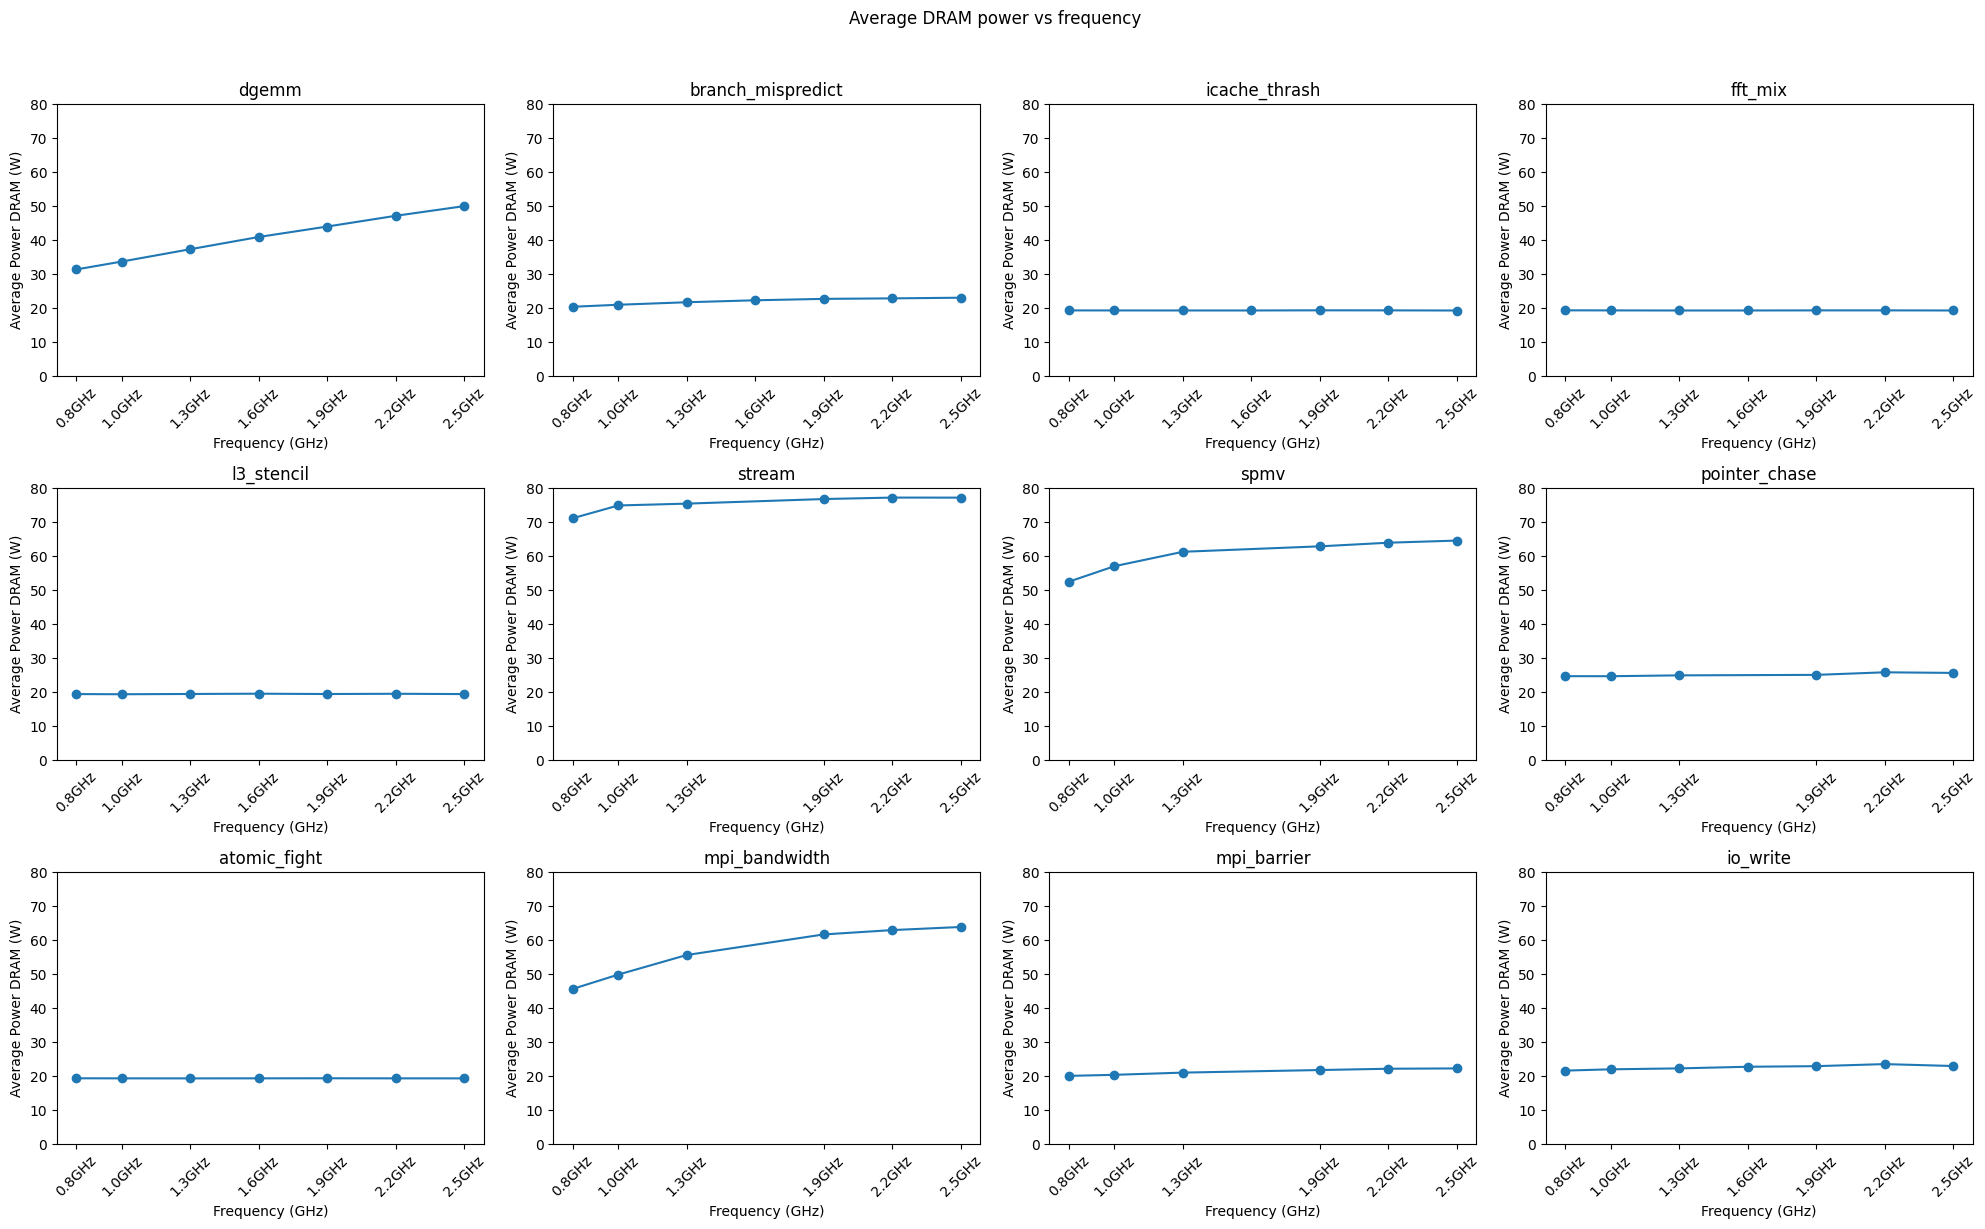

In [173]:
# Plot average Power DRAM [W] vs frequency
import math
import matplotlib.pyplot as plt

dram_power_field = 'Power DRAM [W]'
apps = list(energy_raw.keys())
if 'selected' in globals() and selected:
    apps = [app for app in selected if app in energy_raw]

def build_lookup(pairs):
    return {freq: value for freq, value in pairs}

if apps:
    cols = 4
    rows = math.ceil(len(apps) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes if isinstance(axes, (list, tuple)) else axes.flatten()

    for ax, app in zip(axes, apps):
        freqs = [f for f, _ in energy_raw[app]]
        freqs.sort(key=freq_value)
        avg_dram = []
        xvals = []
        labels = []
        for freq in freqs:
            df = load_energy_profile(app, freq, apps_dir=find_apps_dir(Path.cwd()), group='energy')
            if dram_power_field not in df.columns:
                raise KeyError(f'Missing {dram_power_field} in {app} {freq}')
            avg_dram.append(float(df[dram_power_field].mean()))
            xvals.append(float(freq.replace('GHz', '')))
            labels.append(freq)
        ax.plot(xvals, avg_dram, marker='o')
        ax.set_title(app)
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel('Average Power DRAM (W)')
        ax.set_xticks(xvals, labels, rotation=45)
        ax.set_ylim(0, 80)

    for ax in axes[len(apps):]:
        ax.axis('off')

    fig.suptitle('Average DRAM power vs frequency', y=1.02)
    fig.tight_layout()
    plt.show()


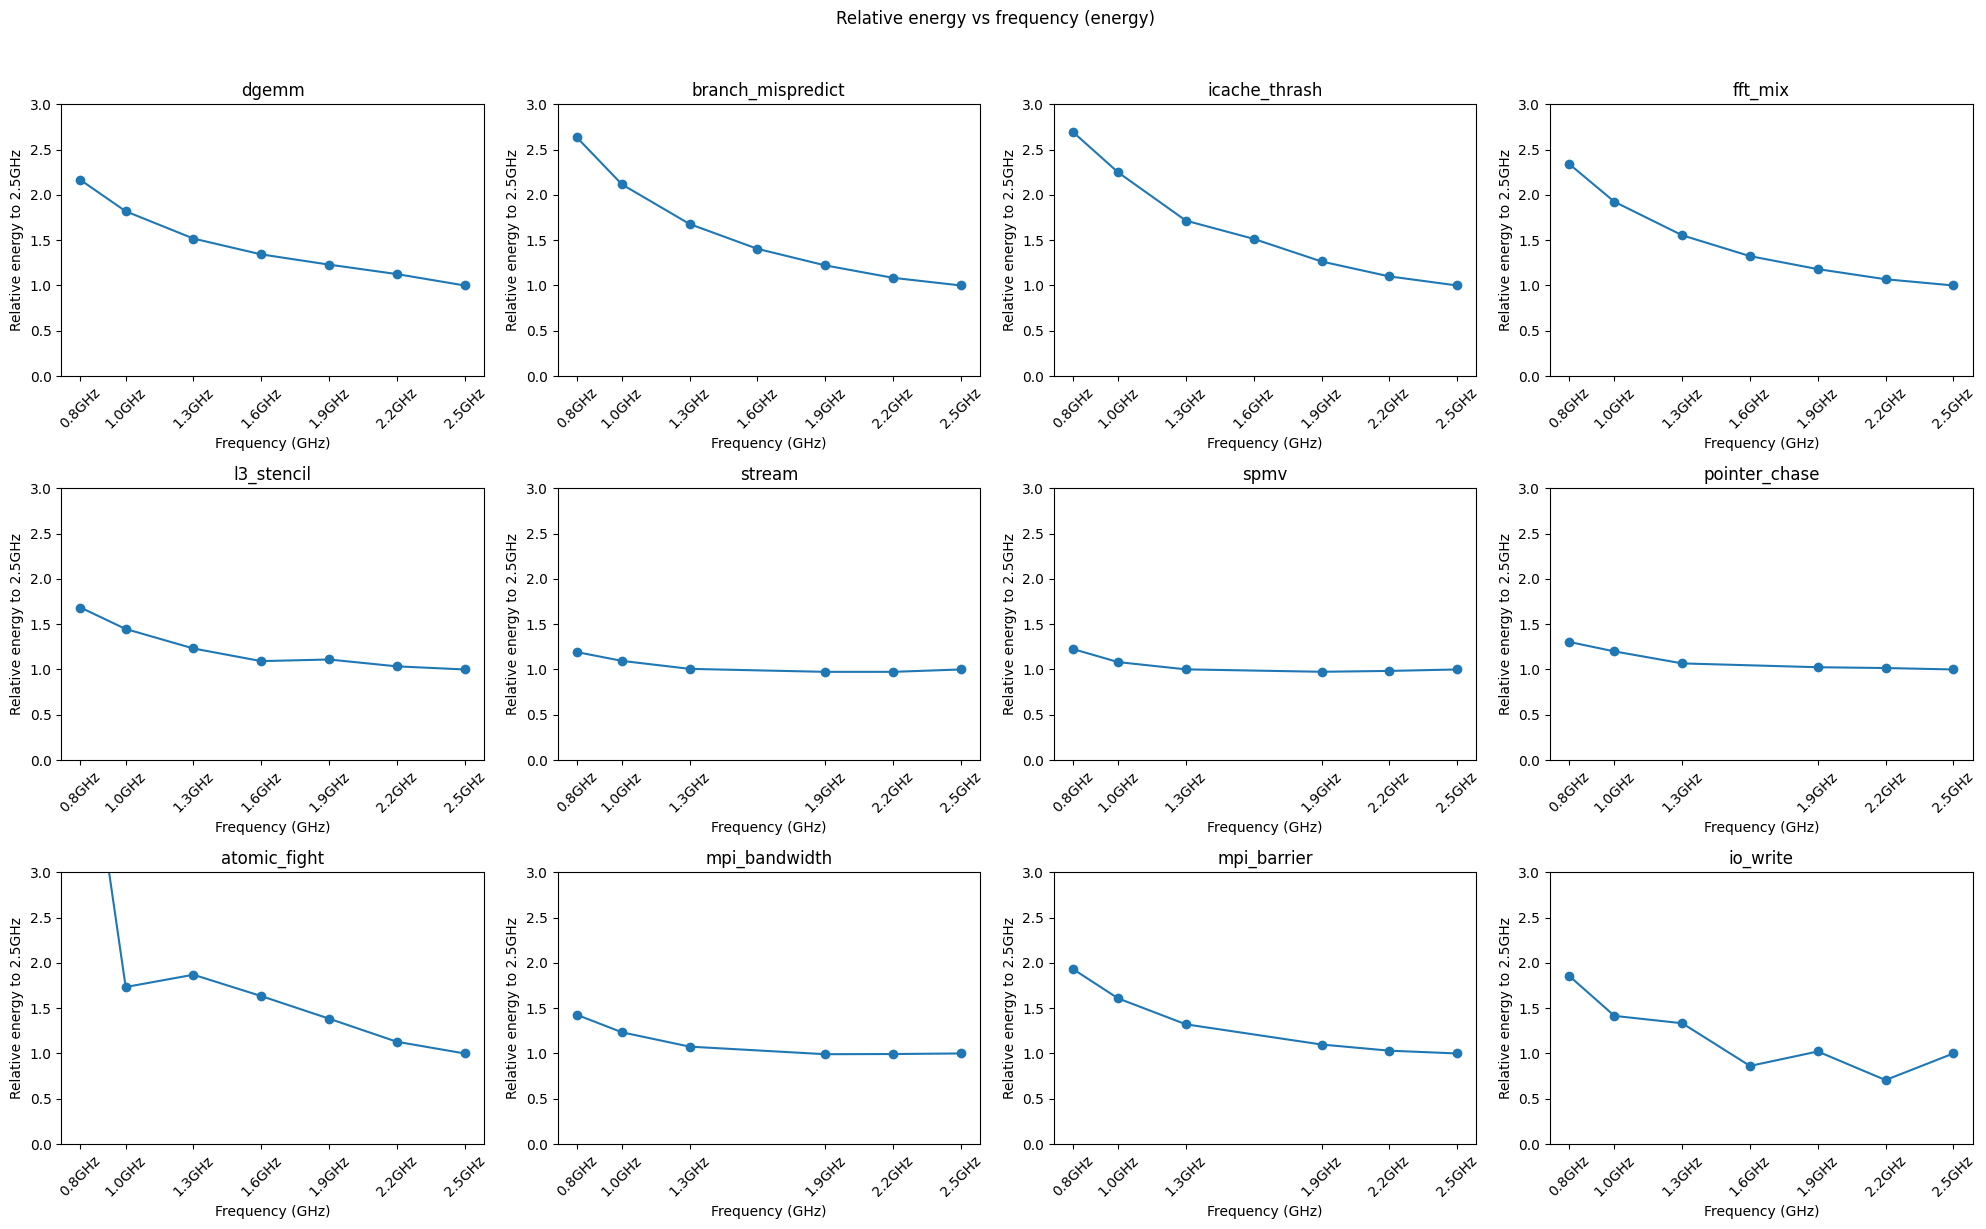

In [174]:
# Plot relative energy vs frequency (uses selected list if defined)
import math
import matplotlib.pyplot as plt

apps = list(energy_results.keys())
if 'selected' in globals() and selected:
    apps = [app for app in selected if app in energy_results]

if apps:
    cols = 4
    rows = math.ceil(len(apps) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes if isinstance(axes, (list, tuple)) else axes.flatten()

    for ax, app in zip(axes, apps):
        freqs = [float(f.replace('GHz', '')) for f, _ in energy_results[app]]
        labels = [f for f, _ in energy_results[app]]
        rel = [e for _, e in energy_results[app]]
        ax.plot(freqs, rel, marker='o')
        ax.set_title(app)
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel(f'Relative energy to {baseline_freq}')
        ax.set_xticks(freqs, labels, rotation=45)
        ax.set_ylim(0, 3)

    for ax in axes[len(apps):]:
        ax.axis('off')

    fig.suptitle('Relative energy vs frequency (energy)', y=1.02)
    fig.tight_layout()
    plt.show()


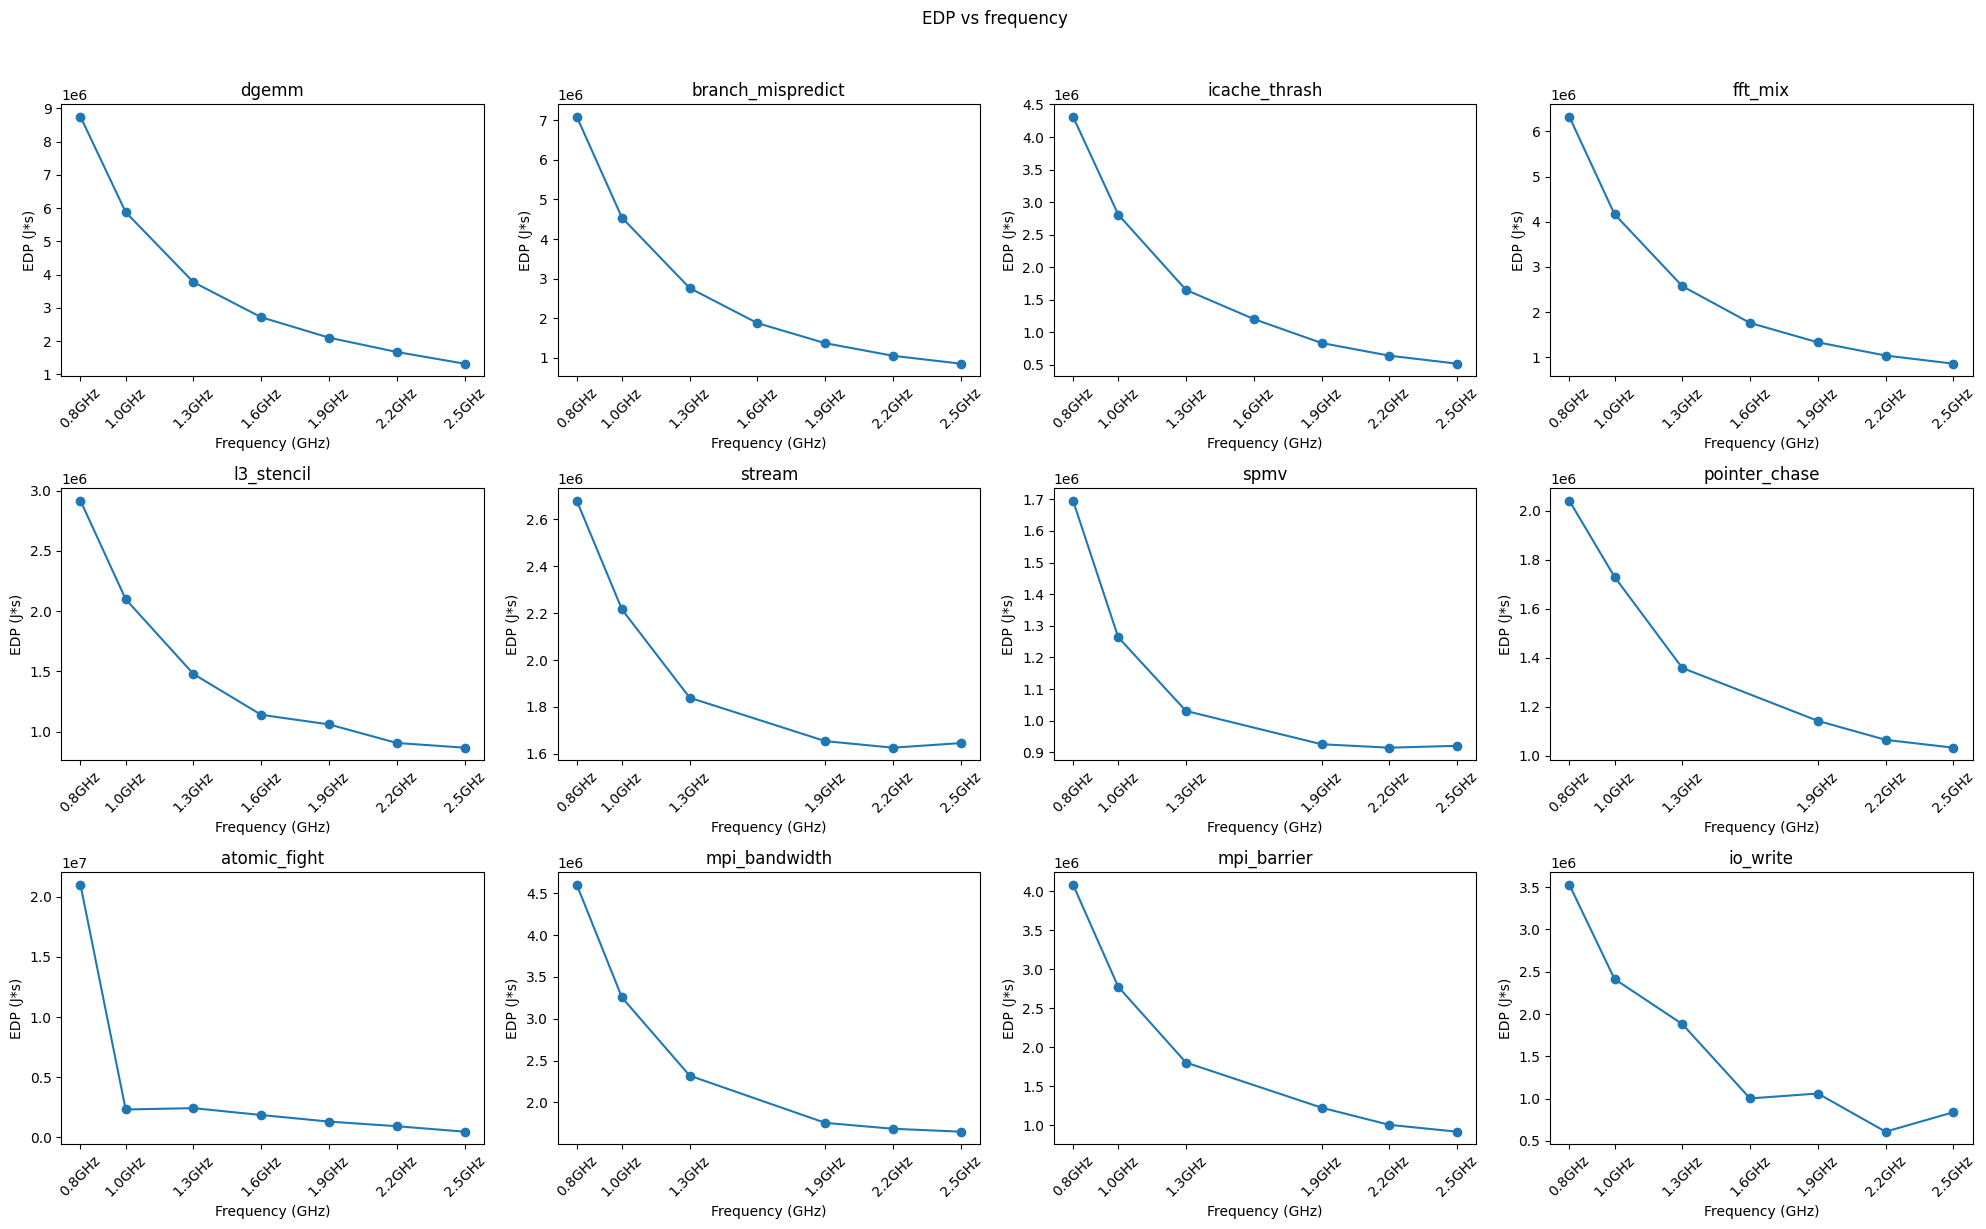

In [175]:
# Plot Energy-Delay Product (EDP) vs frequency (absolute)
import math
import matplotlib.pyplot as plt

apps = sorted(set(raw_results.keys()) & set(energy_raw.keys()))
if 'selected' in globals() and selected:
    apps = [app for app in selected if app in raw_results and app in energy_raw]

def build_lookup(pairs):
    return {freq: value for freq, value in pairs}

if apps:
    cols = 4
    rows = math.ceil(len(apps) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes if isinstance(axes, (list, tuple)) else axes.flatten()

    for ax, app in zip(axes, apps):
        time_map = build_lookup(raw_results[app])
        energy_map = build_lookup(energy_raw[app])
        freqs = [f for f in time_map.keys() if f in energy_map]
        freqs.sort(key=freq_value)
        edp = [time_map[f] * energy_map[f] for f in freqs]
        xvals = [float(f.replace('GHz', '')) for f in freqs]
        ax.plot(xvals, edp, marker='o')
        ax.set_title(app)
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel('EDP (J*s)')
        ax.set_xticks(xvals, freqs, rotation=45)

    for ax in axes[len(apps):]:
        ax.axis('off')

    fig.suptitle('EDP vs frequency', y=1.02)
    fig.tight_layout()
    plt.show()


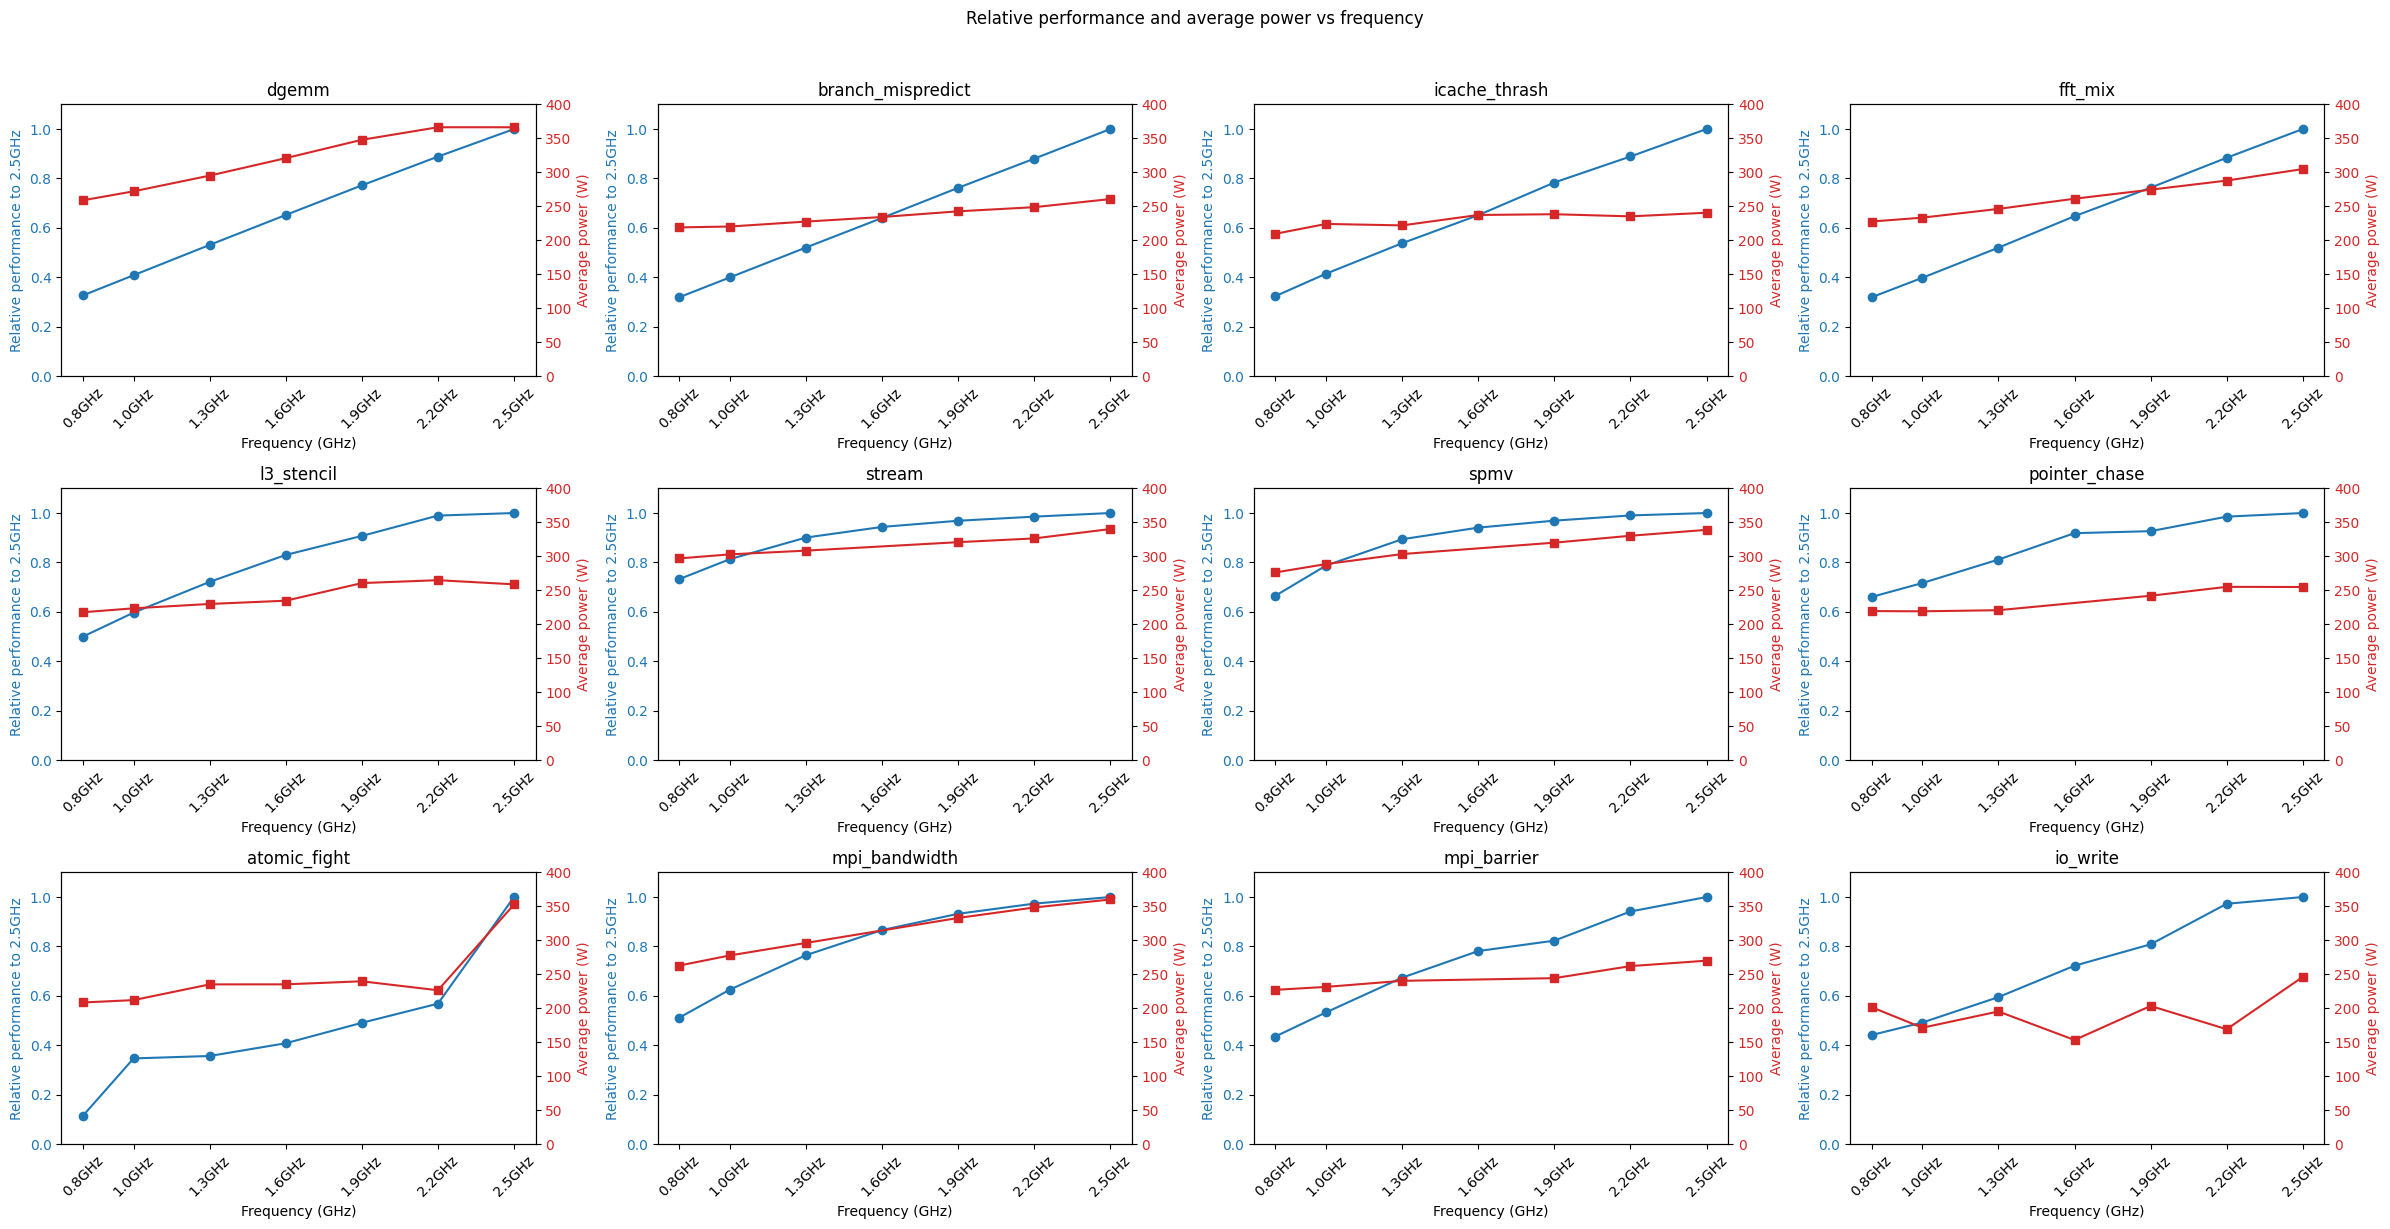

In [178]:
# Plot relative performance (left axis) and average power (right axis)
import math
import matplotlib.pyplot as plt

apps = sorted(set(perf_results.keys()) & set(raw_results.keys()))
if 'selected' in globals() and selected:
    apps = [app for app in selected if app in perf_results and app in raw_results]

def build_lookup(pairs):
    return {freq: value for freq, value in pairs}

if apps:
    cols = 4
    rows = math.ceil(len(apps) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
    axes = axes if isinstance(axes, (list, tuple)) else axes.flatten()

    for ax, app in zip(axes, apps):
        perf_map = build_lookup(perf_results[app])
        raw_time_map = build_lookup(raw_results[app])
        perf_freqs = sorted(perf_map.keys(), key=freq_value)
        if not perf_freqs:
            ax.axis('off')
            continue
        x_perf = [float(f.replace('GHz', '')) for f in perf_freqs]
        ax.plot(x_perf, [perf_map[f] for f in perf_freqs], marker='o', color='tab:blue')
        ax.set_title(app)
        ax.set_xlabel('Frequency (GHz)')
        ax.set_ylabel(f'Relative performance to {baseline_freq}', color='tab:blue')
        ax.set_xticks(x_perf, perf_freqs, rotation=45)
        ax.set_ylim(0, 1.1)
        ax.tick_params(axis='y', labelcolor='tab:blue')

        if app in energy_raw:
            energy_map = build_lookup(energy_raw[app])
            power_freqs = [f for f in perf_freqs if f in energy_map and f in raw_time_map]
            if power_freqs:
                x_power = [float(f.replace('GHz', '')) for f in power_freqs]
                avg_power = [energy_map[f] / raw_time_map[f] for f in power_freqs]
                ax2 = ax.twinx()
                ax2.plot(x_power, avg_power, marker='s', color='tab:red')
                ax2.set_ylabel('Average power (W)', color='tab:red')
                ax2.set_ylim(0, 400)
                ax2.tick_params(axis='y', labelcolor='tab:red')

    for ax in axes[len(apps):]:
        ax.axis('off')

    fig.suptitle('Relative performance and average power vs frequency', y=1.02)
    fig.tight_layout()
    plt.show()
